In [1]:
# import packages that will be used for the logistics regression analysis
import pylab
import seaborn as sb
sb.set(style="white")
sb.set(style="whitegrid", color_codes=True)
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.core.display import HTML
from IPython.display import display
import pandas as pd
from pandas import Series, DataFrame
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# import data set that will be used for the logistics regression analysis
pd.set_option('display.max_columns', None)
df = pd.read_csv (r'C:\Users\fahim\Documents\0_WGUDocuments\d208\1medical_clean.csv')

# rename the item columns accordingly
df.rename(columns={'Item1':'Timely_admis','Item2':'Timely_treat',
 'Item3':'Timely_visits','Item4':'Reliability',
 'Item5':'Options','Item6':'Hrs_treat',
 'Item7':'Courteous','Item8':'Active_listen'},inplace=True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  TimeZone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            10000 non-null  int64  
 15  Age                 10000 non-null  int64  
 16  Incom

# Justification
 Linear regression tries to predict a continuous numerical value by finding the best fitted line to our data. In this case,
 logistic regression is more applicable to our analysis because our goal is to create a categorical prediction which represents the chance of a patient's readmission.

# Data Preprocessing
>Remove any missing or null values, and check for duplicate rows and columns.<br>
>Perform one-hot encoding on categorical features.<br>
>Selecting important features to use for the logistic regression.<br>
>Which features help us make our prediction the most? <br>
>Two feature selection methods I employ are low variance thresholding, and tree-based feature selection<br>
>Feature selection will be used to find the features that are highly correlated with the objective<br>
>Low variance threshold removes features based on its variability. The threshold is a cutoff for the frequency of variablity<br>
>Tree based feature selection <br>

>adjust coeff / weight and how it impacts the decision of the model and if it's right or not<br>

# Dropping demographic columns because KEEP ADDITIONAL_CHARGES AND TOTAL CHARGE

In [2]:
# drop all the demographic columns we don't need for this logistics regression analysis
df.drop(['City','State','County','Area','Zip','Lat','Lng','Population','TimeZone','Additional_charges','TotalCharge','Interaction','UID','Customer_id','Job','CaseOrder'],axis = 1,inplace=True)
# verify that all the columns were dropped before proceeding
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Children            10000 non-null  int64  
 1   Age                 10000 non-null  int64  
 2   Income              10000 non-null  float64
 3   Marital             10000 non-null  object 
 4   Gender              10000 non-null  object 
 5   ReAdmis             10000 non-null  object 
 6   VitD_levels         10000 non-null  float64
 7   Doc_visits          10000 non-null  int64  
 8   Full_meals_eaten    10000 non-null  int64  
 9   vitD_supp           10000 non-null  int64  
 10  Soft_drink          10000 non-null  object 
 11  Initial_admin       10000 non-null  object 
 12  HighBlood           10000 non-null  object 
 13  Stroke              10000 non-null  object 
 14  Complication_risk   10000 non-null  object 
 15  Overweight          10000 non-null  object 
 16  Arthr

In [3]:
#check if there is any duplicate data entries present in columns
df[df.duplicated()]

,Children,Age,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,Timely_admis,Timely_treat,Timely_visits,Reliability,Options,Hrs_treat,Courteous,Active_listen


In [4]:
# check if there are any duplicated columns in the data set - if there are none then the output should be False
df.columns.duplicated().any()

False

In [5]:
# check if there are any duplicated rows in the data set - if there are none then the output should be False
df.duplicated().any()

False

In [6]:
# convert categorical yes/no values to numeric 1/0 values
df = df.replace(to_replace = ['Yes','No'],value = [1,0])
df

,Children,Age,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,Timely_admis,Timely_treat,Timely_visits,Reliability,Options,Hrs_treat,Courteous,Active_listen
0,1,53,86575.93,Divorced,Male,0,19.141466,6,0,0,0,Emergency Admission,1,0,Medium,0,1,1,0,1,1,1,0,1,Blood Work,10.585770,3,3,2,2,4,3,3,4
1,3,51,46805.99,Married,Female,0,18.940352,4,2,1,0,Emergency Admission,1,0,High,1,0,0,0,0,0,0,1,0,Intravenous,15.129562,3,4,3,4,4,4,3,3
2,3,53,14370.14,Widowed,Female,0,18.057507,4,1,0,0,Elective Admission,1,0,Medium,1,0,1,0,0,0,0,0,0,Blood Work,4.772177,2,4,4,4,3,4,3,3
3,0,78,39741.49,Married,Male,0,16.576858,4,1,0,0,Elective Admission,0,1,Medium,0,1,0,0,0,0,0,1,1,Blood Work,1.714879,3,5,5,3,4,5,5,5
4,1,22,1209.56,Widowed,Female,0,17.439069,5,0,2,1,Elective Admission,0,0,Low,0,0,0,1,0,0,1,0,0,CT Scan,1.254807,2,1,3,3,5,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,25,45967.61,Widowed,Male,0,16.980860,4,2,1,0,Emergency Admission,1,0,Medium,0,0,0,0,0,1,0,1,0,Intravenous,51.561220,3,2,2,3,4,3,4,2
9996,4,87,14983.02,Widowed,Male,1,18.177020,5,0,0,0,Elective Admission,1,0,Medium,1,1,1,0,0,0,0,0,1,CT Scan,68.668240,3,3,4,2,5,3,4,4
9997,3,45,65917.81,Separated,Female,1,17.129070,4,2,0,1,Elective Admission,1,0,High,1,0,0,0,0,1,1,0,0,Intravenous,70.154180,3,3,3,4,4,2,3,2
9998,3,43,29702.32,Divorced,Male,1,19.910430,5,2,1,0,Emergency Admission,0,0,Medium,1,0,0,0,1,0,0,0,0,Blood Work,63.356900,5,5,3,4,4,3,4,3


In [7]:
# convert the non-married Marital status values to "Married/Not Married", then convert "Married/Not Married" to "1/0"
#this will make the Marital variable easier to work with during regression analysis
df['Marital'] = df['Marital'].replace(['Divorced','Widowed','Separated','Never Married'],'Not Married')
df['Marital'] = df['Marital'].replace(['Married','Not Married'],[1,0])
df

,Children,Age,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,Timely_admis,Timely_treat,Timely_visits,Reliability,Options,Hrs_treat,Courteous,Active_listen
0,1,53,86575.93,0,Male,0,19.141466,6,0,0,0,Emergency Admission,1,0,Medium,0,1,1,0,1,1,1,0,1,Blood Work,10.585770,3,3,2,2,4,3,3,4
1,3,51,46805.99,1,Female,0,18.940352,4,2,1,0,Emergency Admission,1,0,High,1,0,0,0,0,0,0,1,0,Intravenous,15.129562,3,4,3,4,4,4,3,3
2,3,53,14370.14,0,Female,0,18.057507,4,1,0,0,Elective Admission,1,0,Medium,1,0,1,0,0,0,0,0,0,Blood Work,4.772177,2,4,4,4,3,4,3,3
3,0,78,39741.49,1,Male,0,16.576858,4,1,0,0,Elective Admission,0,1,Medium,0,1,0,0,0,0,0,1,1,Blood Work,1.714879,3,5,5,3,4,5,5,5
4,1,22,1209.56,0,Female,0,17.439069,5,0,2,1,Elective Admission,0,0,Low,0,0,0,1,0,0,1,0,0,CT Scan,1.254807,2,1,3,3,5,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,25,45967.61,0,Male,0,16.980860,4,2,1,0,Emergency Admission,1,0,Medium,0,0,0,0,0,1,0,1,0,Intravenous,51.561220,3,2,2,3,4,3,4,2
9996,4,87,14983.02,0,Male,1,18.177020,5,0,0,0,Elective Admission,1,0,Medium,1,1,1,0,0,0,0,0,1,CT Scan,68.668240,3,3,4,2,5,3,4,4
9997,3,45,65917.81,0,Female,1,17.129070,4,2,0,1,Elective Admission,1,0,High,1,0,0,0,0,1,1,0,0,Intravenous,70.154180,3,3,3,4,4,2,3,2
9998,3,43,29702.32,0,Male,1,19.910430,5,2,1,0,Emergency Admission,0,0,Medium,1,0,0,0,1,0,0,0,0,Blood Work,63.356900,5,5,3,4,4,3,4,3


In [8]:
# Showcase the unique values for the Services variable
df['Gender'].unique()

array(['Male', 'Female', 'Nonbinary'], dtype=object)

In [9]:
#convert the non-Female gender values to "Female/non-female", then convert "Female/non-female" to "1/0"
df['Gender'] = df['Gender'].replace(['Male','Nonbinary'],'non-female')
df['Gender'] = df['Gender'].replace(['Female','non-female'],[1,0])
df

,Children,Age,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,Timely_admis,Timely_treat,Timely_visits,Reliability,Options,Hrs_treat,Courteous,Active_listen
0,1,53,86575.93,0,0,0,19.141466,6,0,0,0,Emergency Admission,1,0,Medium,0,1,1,0,1,1,1,0,1,Blood Work,10.585770,3,3,2,2,4,3,3,4
1,3,51,46805.99,1,1,0,18.940352,4,2,1,0,Emergency Admission,1,0,High,1,0,0,0,0,0,0,1,0,Intravenous,15.129562,3,4,3,4,4,4,3,3
2,3,53,14370.14,0,1,0,18.057507,4,1,0,0,Elective Admission,1,0,Medium,1,0,1,0,0,0,0,0,0,Blood Work,4.772177,2,4,4,4,3,4,3,3
3,0,78,39741.49,1,0,0,16.576858,4,1,0,0,Elective Admission,0,1,Medium,0,1,0,0,0,0,0,1,1,Blood Work,1.714879,3,5,5,3,4,5,5,5
4,1,22,1209.56,0,1,0,17.439069,5,0,2,1,Elective Admission,0,0,Low,0,0,0,1,0,0,1,0,0,CT Scan,1.254807,2,1,3,3,5,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,25,45967.61,0,0,0,16.980860,4,2,1,0,Emergency Admission,1,0,Medium,0,0,0,0,0,1,0,1,0,Intravenous,51.561220,3,2,2,3,4,3,4,2
9996,4,87,14983.02,0,0,1,18.177020,5,0,0,0,Elective Admission,1,0,Medium,1,1,1,0,0,0,0,0,1,CT Scan,68.668240,3,3,4,2,5,3,4,4
9997,3,45,65917.81,0,1,1,17.129070,4,2,0,1,Elective Admission,1,0,High,1,0,0,0,0,1,1,0,0,Intravenous,70.154180,3,3,3,4,4,2,3,2
9998,3,43,29702.32,0,0,1,19.910430,5,2,1,0,Emergency Admission,0,0,Medium,1,0,0,0,1,0,0,0,0,Blood Work,63.356900,5,5,3,4,4,3,4,3


In [10]:
# Showcase the unique values for the Services variable
df['Services'].unique()

array(['Blood Work', 'Intravenous', 'CT Scan', 'MRI'], dtype=object)

In [11]:
# Drop the services variable since these values cannot be condensed
df.drop(['Services'],axis = 1,inplace=True)

In [12]:
# Showcase the unique values for the Complication_risk variable
df['Complication_risk'].unique()

array(['Medium', 'High', 'Low'], dtype=object)

In [13]:
# Drop the services variable since these values cannot be condensed
df.drop(['Complication_risk'],axis = 1,inplace=True)

In [14]:
# Showcase the unique values for the Initial_admin variable
df['Initial_admin'].unique()

array(['Emergency Admission', 'Elective Admission',
       'Observation Admission'], dtype=object)

In [15]:
# convert the non-emergency admission status values to "Emergency Admission/non-Emergency Admission", then convert "Emergency Admission/non-Emergency Admission" to "1/0"
#this will make the Marital variable easier to work with during regression analysis
df['Initial_admin'] = df['Initial_admin'].replace(['Elective Admission','Observation Admission'],'non-Emergency Admission')
df['Initial_admin'] = df['Initial_admin'].replace(['Emergency Admission','non-Emergency Admission'],[1,0])
df

,Children,Age,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Initial_days,Timely_admis,Timely_treat,Timely_visits,Reliability,Options,Hrs_treat,Courteous,Active_listen
0,1,53,86575.93,0,0,0,19.141466,6,0,0,0,1,1,0,0,1,1,0,1,1,1,0,1,10.585770,3,3,2,2,4,3,3,4
1,3,51,46805.99,1,1,0,18.940352,4,2,1,0,1,1,0,1,0,0,0,0,0,0,1,0,15.129562,3,4,3,4,4,4,3,3
2,3,53,14370.14,0,1,0,18.057507,4,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,4.772177,2,4,4,4,3,4,3,3
3,0,78,39741.49,1,0,0,16.576858,4,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1.714879,3,5,5,3,4,5,5,5
4,1,22,1209.56,0,1,0,17.439069,5,0,2,1,0,0,0,0,0,0,1,0,0,1,0,0,1.254807,2,1,3,3,5,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,25,45967.61,0,0,0,16.980860,4,2,1,0,1,1,0,0,0,0,0,0,1,0,1,0,51.561220,3,2,2,3,4,3,4,2
9996,4,87,14983.02,0,0,1,18.177020,5,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,68.668240,3,3,4,2,5,3,4,4
9997,3,45,65917.81,0,1,1,17.129070,4,2,0,1,0,1,0,1,0,0,0,0,1,1,0,0,70.154180,3,3,3,4,4,2,3,2
9998,3,43,29702.32,0,0,1,19.910430,5,2,1,0,1,0,0,1,0,0,0,1,0,0,0,0,63.356900,5,5,3,4,4,3,4,3


In [16]:
# describe the dataframe and showcase summary statistics of the variables
df.describe()

,Children,Age,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Initial_days,Timely_admis,Timely_treat,Timely_visits,Reliability,Options,Hrs_treat,Courteous,Active_listen
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.097200,53.511700,40490.495160,0.202300,0.501800,0.366900,17.964262,5.012200,1.001400,0.398900,0.257500,0.506000,0.409000,0.199300,0.709400,0.357400,0.27380,0.337200,0.411400,0.321500,0.394100,0.413500,0.28930,34.455299,3.518800,3.506700,3.511100,3.515100,3.496900,3.522500,3.494000,3.509700
std,2.163659,20.638538,28521.153293,0.401735,0.500022,0.481983,2.017231,1.045734,1.008117,0.628505,0.437279,0.499989,0.491674,0.399494,0.454062,0.479258,0.44593,0.472777,0.492112,0.467076,0.488681,0.492486,0.45346,26.309341,1.031966,1.034825,1.032755,1.036282,1.030192,1.032376,1.021405,1.042312
min,0.000000,18.000000,154.080000,0.000000,0.000000,0.000000,9.806483,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.001981,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,36.000000,19598.775000,0.000000,0.000000,0.000000,16.626439,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7.896215,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,1.000000,53.000000,33768.420000,0.000000,1.000000,0.000000,17.951122,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,35.836244,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000
75%,3.000000,71.000000,54296.402500,0.000000,1.000000,1.000000,19.347963,6.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,61.161020,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,10.000000,89.000000,207249.100000,1.000000,1.000000,1.000000,26.394449,9.000000,7.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,71.981490,8.000000,7.000000,8.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [17]:
# now that all the modifications have been made, export the prepared dataset
df.to_csv(r'C:\Users\fahim\Documents\0_WGUDocuments\d208\2medical_clean-PREPAREDTASK2_12-24-2022.csv')

0    6331
1    3669
Name: ReAdmis, dtype: int64


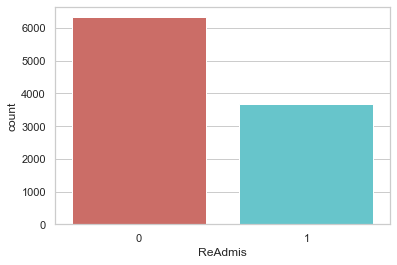

In [18]:
# Start to visualize the data, including univariate and bivariate analyses
# begin by visualizing the target variable, ReAdmis
print(df['ReAdmis'].value_counts())
sb.countplot(x='ReAdmis', data=df, palette='hls')
plt.show()

In [19]:
# identify the columns for variables
Variables = df.select_dtypes(include = "number").columns
print (Variables)

Index(['Children', 'Age', 'Income', 'Marital', 'Gender', 'ReAdmis',
       'VitD_levels', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp',
       'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke', 'Overweight',
       'Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Anxiety',
       'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'Initial_days',
       'Timely_admis', 'Timely_treat', 'Timely_visits', 'Reliability',
       'Options', 'Hrs_treat', 'Courteous', 'Active_listen'],
      dtype='object')


<Figure size 1080x1080 with 0 Axes>

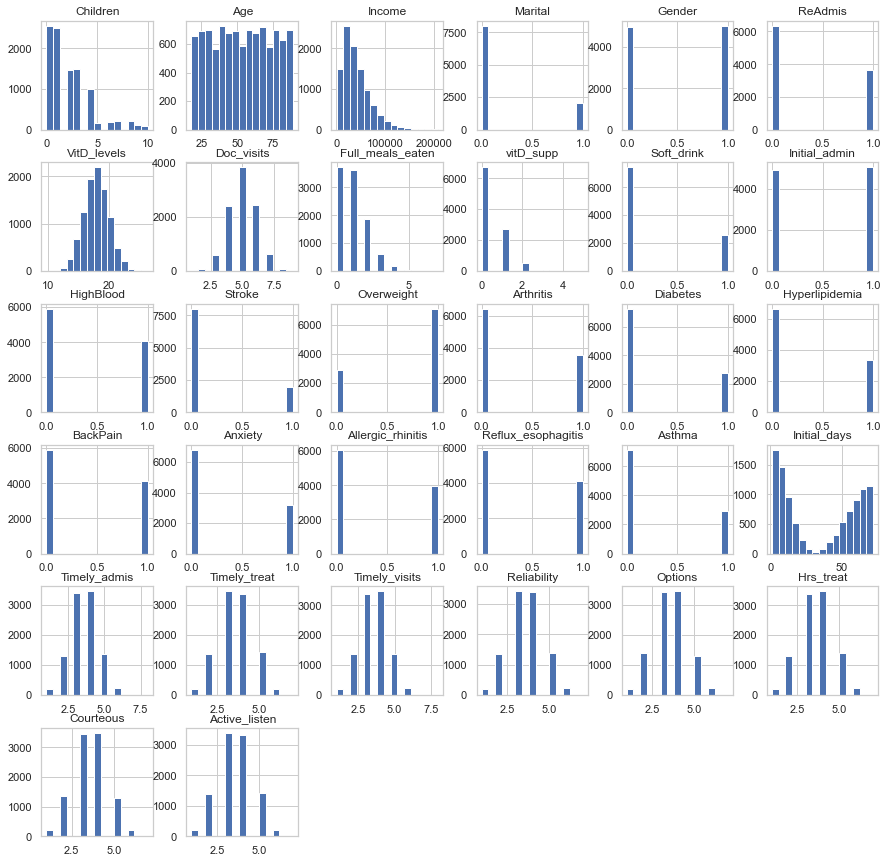

In [20]:
# create histogram plots of the identified predictor variables
fig = plt.figure(figsize=(15, 15))
ax = df[Variables].hist(bins = 15, figsize=(15,15))
plt.title('Variables')
fig.tight_layout(h_pad=5, w_pad=5)
plt.show()

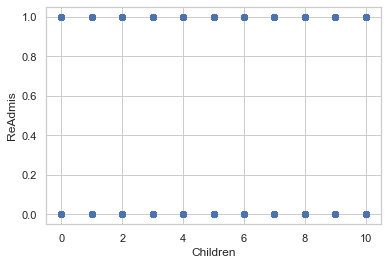

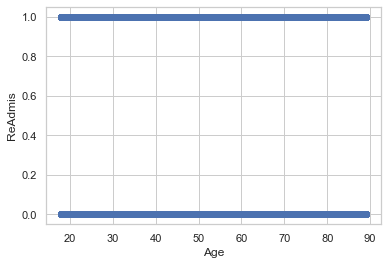

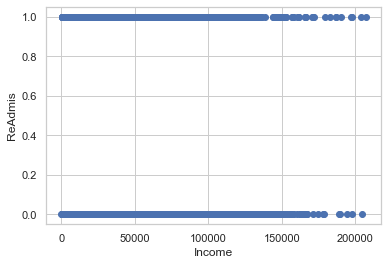

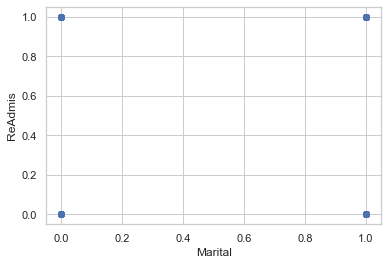

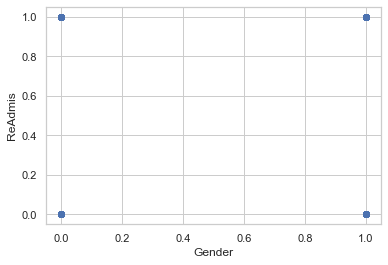

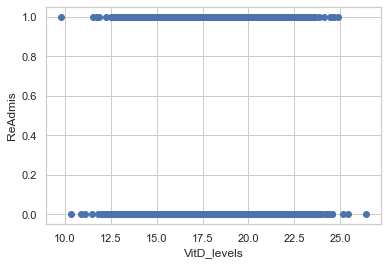

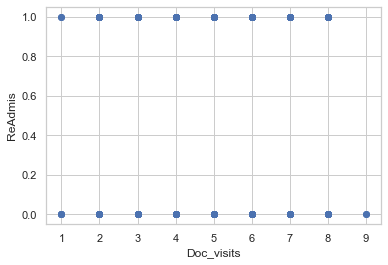

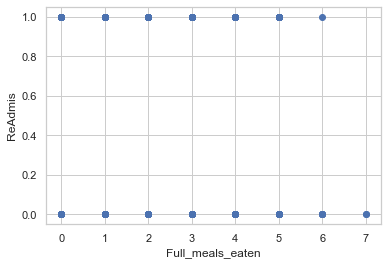

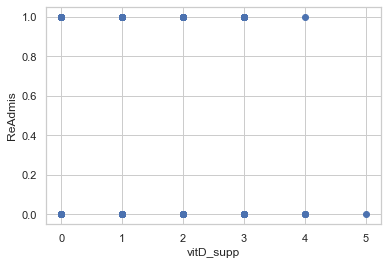

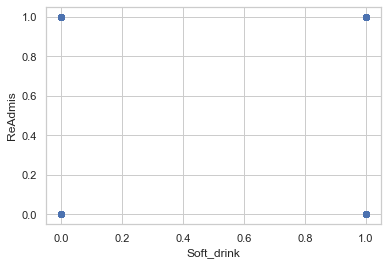

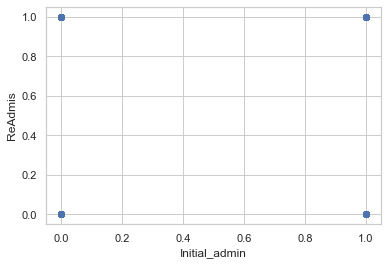

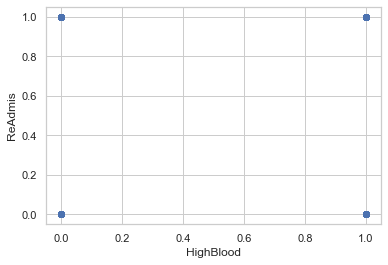

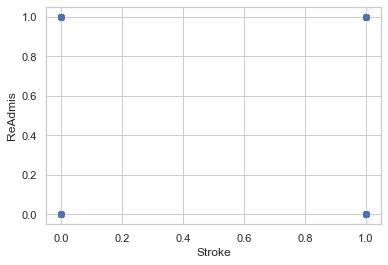

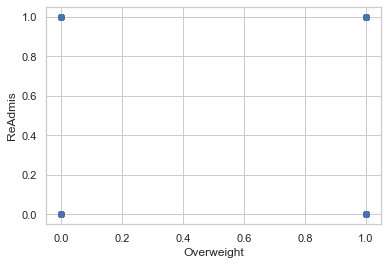

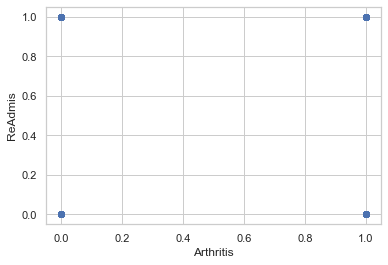

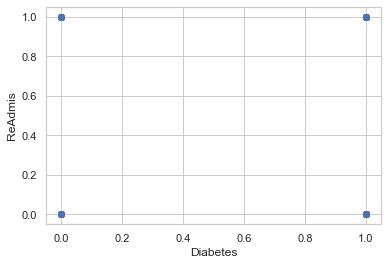

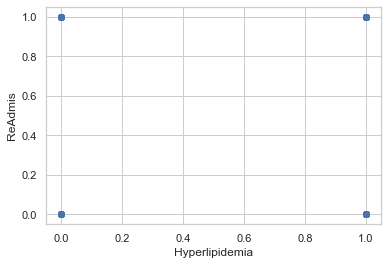

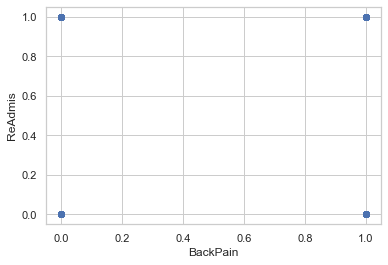

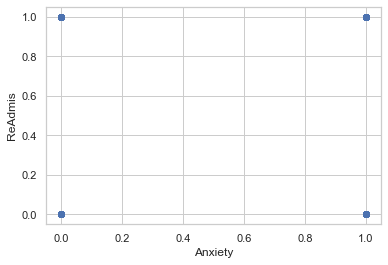

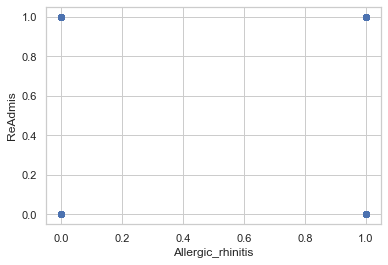

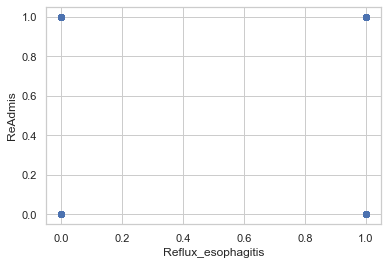

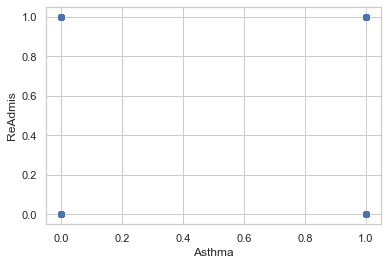

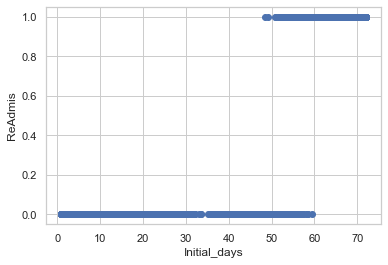

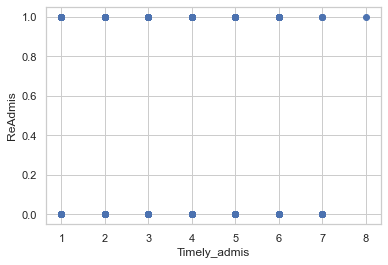

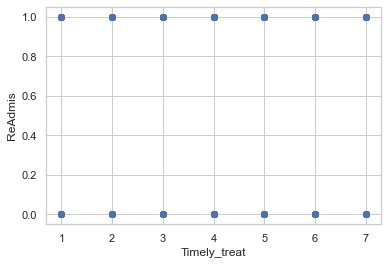

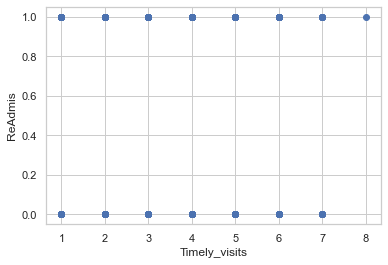

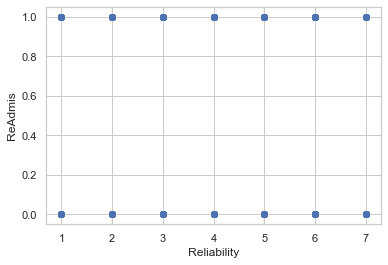

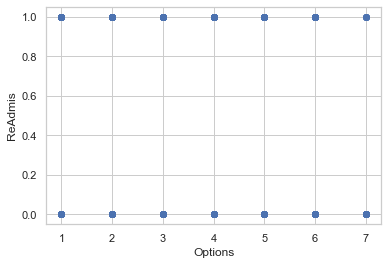

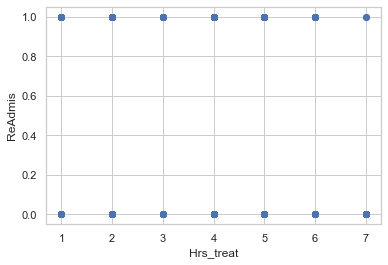

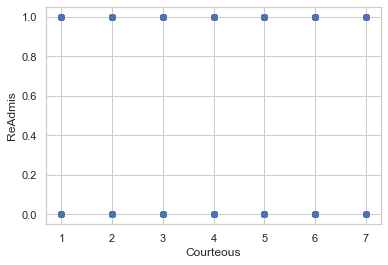

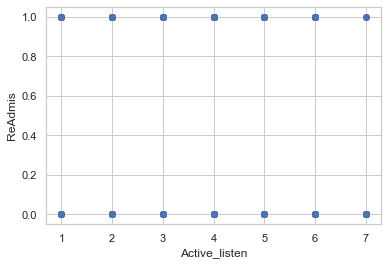

In [21]:
#selecting the target varialbe and showcasing the bivariate statistics

X=df.drop('ReAdmis',inplace=False, axis=1)
y=df['ReAdmis']

for column in X.columns:
    plt.scatter(X[column],y)
    plt.xlabel(column)
    plt.ylabel('ReAdmis')
    plt.show()

In [22]:
# create the initial logistics model
log_reg_results = sm.Logit(df["ReAdmis"], df[['Children', 'Age', 'Income', 'Marital', 'Gender', 'VitD_levels', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp','Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke', 'Overweight','Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Anxiety','Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'Initial_days','Timely_admis', 'Timely_treat', 'Timely_visits', 'Reliability','Options', 'Hrs_treat', 'Courteous', 'Active_listen']]).fit()
print(log_reg_results.summary())

Optimization terminated successfully.
         Current function value: 0.107566
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                ReAdmis   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9969
Method:                           MLE   Df Model:                           30
Date:                Sun, 25 Dec 2022   Pseudo R-squ.:                  0.8363
Time:                        00:14:04   Log-Likelihood:                -1075.7
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Children               0.0050      0.025      0.200      0.841      -0.044       0.054
Age 

In [23]:
# create the correlation matrix
matrix_df = pd.read_csv(r'C:\Users\fahim\Documents\0_WGUDocuments\d208\2medical_clean-PREPAREDTASK2_12-24-2022.csv')

matrix_df = matrix_df[['Children', 'Age', 'Income', 'Marital', 'Gender', 'VitD_levels', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp','Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke', 'Overweight','Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Anxiety','Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'Initial_days','Timely_admis', 'Timely_treat', 'Timely_visits', 'Reliability','Options', 'Hrs_treat', 'Courteous', 'Active_listen','ReAdmis']]

X = matrix_df.iloc[:, 1:-1].values
y = matrix_df.iloc[:,-1].values

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [25]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

C:\Users\fahim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [26]:
y_pred = classifier.predict(X_test)

In [27]:
#now create the confusion matrix for the initial model
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[1189   73]
 [  50  688]]


<AxesSubplot:>

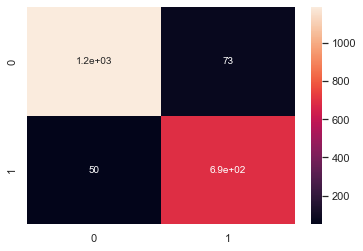

In [28]:
y_predict_test = classifier.predict(X_test)
new_matrix = confusion_matrix(y_test, y_predict_test)
sb.heatmap(new_matrix, annot=True)

Its better to be safe than sorry, so false postive is ok
Actual class on x axis, predicted on y axis,
73 instances of a false negative = no readmission
1189 true negatives
50 false positives
688 true negatives
goes in line with what the data shows, i.e more no readmissions
so that the model is working, and i further confirm this by showing the precision and recall score
formula for precision, recal, f1, explain and understand what they represent

In [29]:
#retrieve the classificaiton report for the initial model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1262
           1       0.90      0.93      0.92       738

    accuracy                           0.94      2000
   macro avg       0.93      0.94      0.93      2000
weighted avg       0.94      0.94      0.94      2000



In [30]:
#Create the reduced model with the variables that had a P value below .05 statistical significance level
log_reg_results2 = sm.Logit(df["ReAdmis"], df[['Age', 'Income', 'Gender', 'VitD_levels', 'Doc_visits', 'vitD_supp','Initial_admin', 'Overweight','Arthritis', 'Anxiety','Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'Initial_days','Timely_admis', 'Timely_visits', 'Reliability','Options', 'Hrs_treat', 'Courteous', 'Active_listen']]).fit()
print(log_reg_results2.summary())

Optimization terminated successfully.
         Current function value: 0.107964
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                ReAdmis   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9979
Method:                           MLE   Df Model:                           20
Date:                Sun, 25 Dec 2022   Pseudo R-squ.:                  0.8357
Time:                        00:14:04   Log-Likelihood:                -1079.6
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.0138      0.003     -5.099      0.000      -0.019      -0.009
Inco

In [31]:
# create the correlation matrix for the reduced model
matrix_df = pd.read_csv(r'C:\Users\fahim\Documents\0_WGUDocuments\d208\2medical_clean-PREPAREDTASK2_12-24-2022.csv')

matrix_df = matrix_df[['Age', 'Income', 'Gender', 'VitD_levels', 'Doc_visits', 'vitD_supp','Initial_admin', 'Overweight','Arthritis', 'Anxiety','Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'Initial_days','Timely_admis', 'Timely_visits', 'Reliability','Options', 'Hrs_treat', 'Courteous', 'Active_listen','ReAdmis']]

X = matrix_df.iloc[:, 1:-1].values
y = matrix_df.iloc[:,-1].values

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [33]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

C:\Users\fahim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [34]:
y_pred = classifier.predict(X_test)

In [35]:
#now create the confusion matrix for the reduced model
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[1193   69]
 [  37  701]]


<AxesSubplot:>

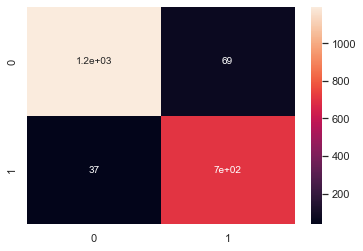

In [36]:
y_predict_test = classifier.predict(X_test)
new_matrix = confusion_matrix(y_test, y_predict_test)
sb.heatmap(new_matrix, annot=True)

In [37]:
#retrieve the classificaiton report for the reduced model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1262
           1       0.91      0.95      0.93       738

    accuracy                           0.95      2000
   macro avg       0.94      0.95      0.94      2000
weighted avg       0.95      0.95      0.95      2000



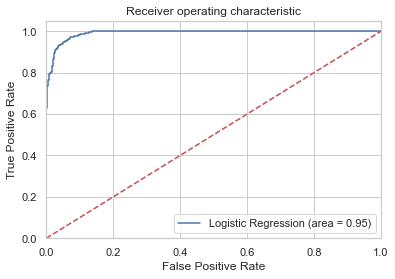

In [38]:
# plot ROC Curve
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' %logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [39]:
# create an equation of the regression
print('Logit: {:.2f}'.format(logit_roc_auc))
equation = log_reg_results2.summary().tables[1]
print('Estimate [{}] as L = '.format(log_reg_results2.summary().tables[0][1][1]))
equation = pd.DataFrame(equation)
for i in equation.itertuples():
    print(' {:+.3f} x ( {} ) '.format(i[0],i[1]))

Logit: 0.95
Estimate [Logit] as L = 
 +0.000 x (  ) 
 +1.000 x ( Age ) 
 +2.000 x ( Income ) 
 +3.000 x ( Gender ) 
 +4.000 x ( VitD_levels ) 
 +5.000 x ( Doc_visits ) 
 +6.000 x ( vitD_supp ) 
 +7.000 x ( Initial_admin ) 
 +8.000 x ( Overweight ) 
 +9.000 x ( Arthritis ) 
 +10.000 x ( Anxiety ) 
 +11.000 x ( Allergic_rhinitis ) 
 +12.000 x ( Reflux_esophagitis ) 
 +13.000 x ( Asthma ) 
 +14.000 x ( Initial_days ) 
 +15.000 x ( Timely_admis ) 
 +16.000 x ( Timely_visits ) 
 +17.000 x ( Reliability ) 
 +18.000 x ( Options ) 
 +19.000 x ( Hrs_treat ) 
 +20.000 x ( Courteous ) 
 +21.000 x ( Active_listen ) 


In [40]:
print(equation)

                     0           1          2          3       4          5  \
0                             coef    std err          z   P>|z|     [0.025   
1                  Age     -0.0138      0.003     -5.099   0.000     -0.019   
2               Income  -6.401e-06   1.91e-06     -3.350   0.001  -1.01e-05   
3               Gender     -0.3735      0.111     -3.356   0.001     -0.592   
4          VitD_levels     -0.4562      0.025    -18.004   0.000     -0.506   
5           Doc_visits     -0.4580      0.052     -8.803   0.000     -0.560   
6            vitD_supp     -0.1902      0.086     -2.206   0.027     -0.359   
7        Initial_admin      0.4636      0.111      4.176   0.000      0.246   
8           Overweight     -0.4015      0.121     -3.315   0.001     -0.639   
9            Arthritis     -0.5081      0.115     -4.430   0.000     -0.733   
10             Anxiety     -0.3776      0.118     -3.199   0.001     -0.609   
11   Allergic_rhinitis     -0.3773      0.113     -3

In [41]:
updated_equation = equation.drop(0)

In [42]:
print(updated_equation)

                     0           1          2          3       4          5  \
1                  Age     -0.0138      0.003     -5.099   0.000     -0.019   
2               Income  -6.401e-06   1.91e-06     -3.350   0.001  -1.01e-05   
3               Gender     -0.3735      0.111     -3.356   0.001     -0.592   
4          VitD_levels     -0.4562      0.025    -18.004   0.000     -0.506   
5           Doc_visits     -0.4580      0.052     -8.803   0.000     -0.560   
6            vitD_supp     -0.1902      0.086     -2.206   0.027     -0.359   
7        Initial_admin      0.4636      0.111      4.176   0.000      0.246   
8           Overweight     -0.4015      0.121     -3.315   0.001     -0.639   
9            Arthritis     -0.5081      0.115     -4.430   0.000     -0.733   
10             Anxiety     -0.3776      0.118     -3.199   0.001     -0.609   
11   Allergic_rhinitis     -0.3773      0.113     -3.346   0.001     -0.598   
12  Reflux_esophagitis     -0.3738      0.113     -3

In [43]:
# create an equation of the logistics regression
print('Logit: {:.2f}'.format(logit_roc_auc))
print('Estimate [{}] as L = '.format(log_reg_results2.summary().tables[0][1][1]))
for i in updated_equation.itertuples():
    print(' {:+.3f} x ( {} ) '.format(float(str(i[2])),i[1]))

Logit: 0.95
Estimate [Logit] as L = 
 -0.014 x ( Age ) 
 -0.000 x ( Income ) 
 -0.373 x ( Gender ) 
 -0.456 x ( VitD_levels ) 
 -0.458 x ( Doc_visits ) 
 -0.190 x ( vitD_supp ) 
 +0.464 x ( Initial_admin ) 
 -0.402 x ( Overweight ) 
 -0.508 x ( Arthritis ) 
 -0.378 x ( Anxiety ) 
 -0.377 x ( Allergic_rhinitis ) 
 -0.374 x ( Reflux_esophagitis ) 
 -0.425 x ( Asthma ) 
 +0.404 x ( Initial_days ) 
 +0.183 x ( Timely_admis ) 
 -0.285 x ( Timely_visits ) 
 -0.500 x ( Reliability ) 
 -0.916 x ( Options ) 
 -0.317 x ( Hrs_treat ) 
 -0.349 x ( Courteous ) 
 -0.362 x ( Active_listen ) 
